# Что нейронные сети знают о наших лицах?
Мастер-класс Емельяненко Дмитрия(https://github.com/TIXFeniks) и Творожков Андрей(https://github.com/tvorogme)
школа GoTo(https://goto.msk.ru) at DigitalFes(http://digitalfest.ru)

### Подключим необходимые библиотеки

In [2]:
%load_ext autoreload
%autoreload 2

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.neighbors import LSHForest



# Загрузим датасет
Данные были уже загружены специально для вас. Ссылки (на всякий случай):
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [4]:
X, attr = load_lfw_dataset(use_raw=True,dimx=38,dimy=38)
m_attr = attr.as_matrix()
X = X.astype('float32') / 255.0

img_shape = X.shape[1:]

X_train, X_test, attr_train, attr_test = train_test_split(X, m_attr, test_size=0.1, random_state=42)

X shape: (13143, 38, 38, 3)
attr shape: (13143, 73)


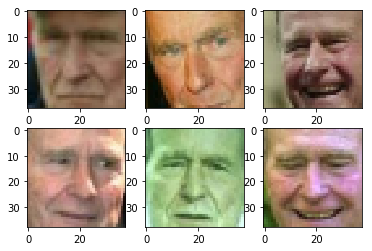

In [5]:
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])

print("X shape:",X.shape)
print("attr shape:",attr.shape)

##  Модель

Для манипуляций с лицами мы будем использовать автокодировщик. Эту модель мы учим сжимать картинку до вектора малой размерности и разжимать её обратно, теряя как можно меньше инфромации.

<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg">

За время мастер-класса мы не успеем обучить модель с нуля, так что мы предобучили модель заранее, дальнейший код загружает модель.

In [31]:
from autoencoder import load_autoencoder
autoencoder = load_autoencoder(img_shape, weights_file= "") 
# gan4.pkl - это весело! Попробуй и другие .pkl файлы из папки с этой тетрадкой

## Визуализация

Используем нашу модель для того, чтобы сжать картинки. Затем разожмём их обратно

In [32]:
def visualize(img,autoencoder):
    """Draws original, encoded and decoded images"""
    code = autoencoder.encode(img[None])[0]
    reco = autoencoder.decode(code[None])[0]
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//8,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1))
    plt.show()


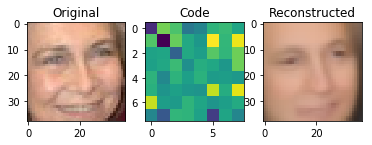

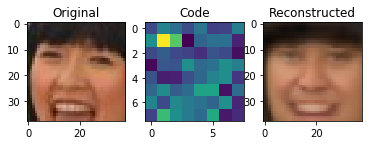

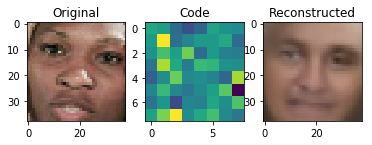

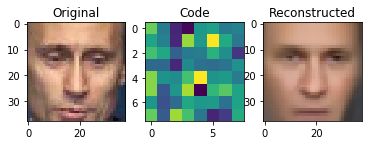

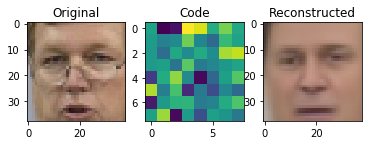

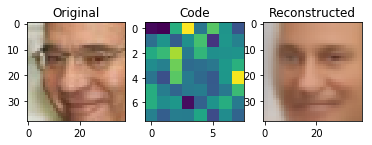

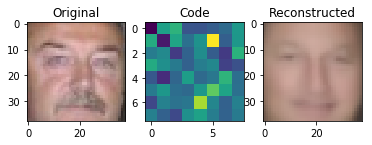

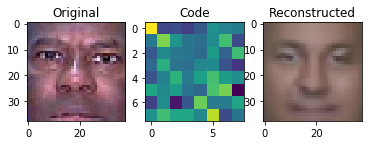

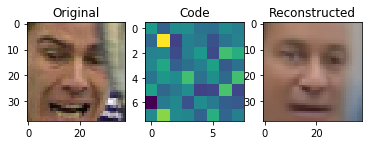

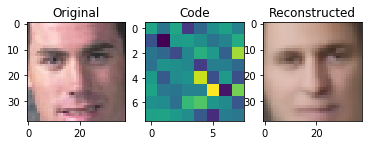

In [33]:
for i in range(10):
    img = X_test[i]
    visualize(img,autoencoder)


## Поиск картинок с помощью автокодировщиков
Нам удалось научить модель сжимать картинки и восстанавливать их неточно. С первого взгляда, решение этой задачи не приносит большой пользы, но, решив её, мы получили несколько интересных побочных эффектов.

Первым полезным применением нашей модели является поиск схожих изображений по сгенерированным кодам картинок.

Сперва закодируем наши изображения(не разкодируя обратно в картинки). Затем найдём близкие векторы-коды в нашей базе и покажем соответствующие им изображения как поисковую выдачу.

Импользуем локально чувствительное хэширование(LSH) для ускорения процесса поиска. Для простоты, возьмём <a href="http://scikit-learn.org/0.18/modules/generated/sklearn.neighbors.LSHForest.html#sklearn.neighbors.LSHForest"> реализацию из scikit-learn</a>

In [40]:
# закодируем изображения
images = X_train
codes = autoencoder.encode(images)

In [41]:
# build hashes
lshf = LSHForest(n_estimators=50).fit(codes)

In [42]:
# Функция нахождения схожих изображений
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = autoencoder.encode(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [51]:
# Визуализация похожих изображений
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')

        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

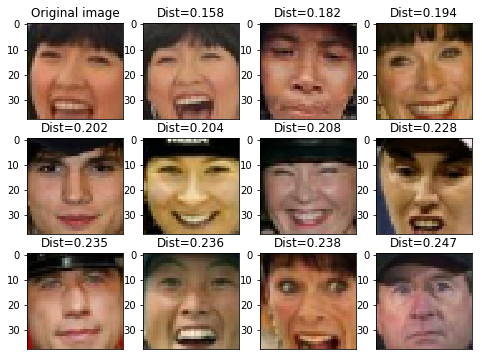

In [52]:
# улыбки
show_similar(X_test[1])

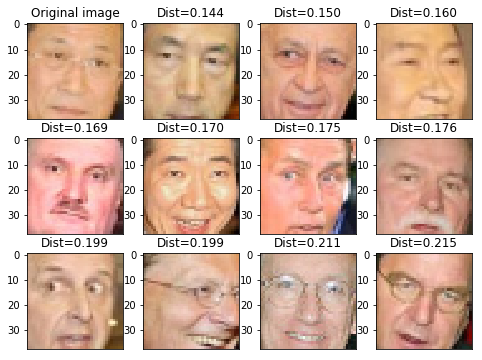

In [54]:
# Национальность
show_similar(X_test[499])

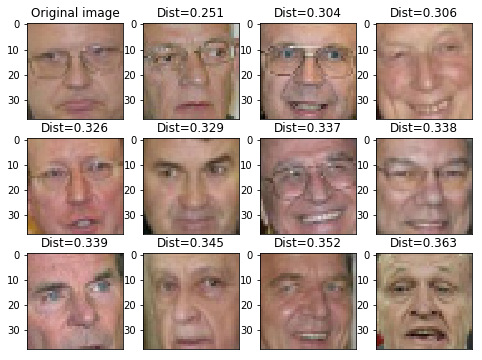

In [59]:
# очки
show_similar(X_test[63])

## преобразование картинок
Вторым, менее полезным, но не менее наглядным примером использования нашей модели будет нахождение промежуточных изображений при переходе от одной картинки к другой

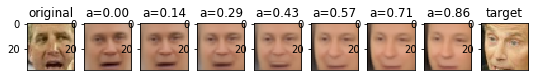

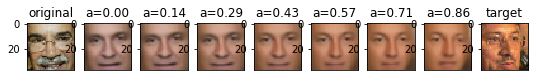

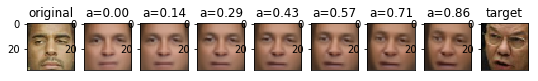

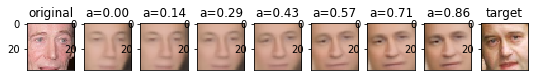

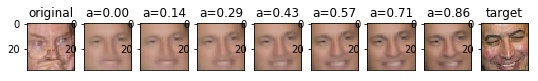

In [68]:
N_INTERMEDIATE = 8
for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = autoencoder.encode(np.stack([image1,image2]))

    plt.figure(figsize=[10,4])
    plt.subplot(1,N_INTERMEDIATE+2,1)
    plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
    plt.imshow(image1)
    plt.title("original")
    for i,a in enumerate(np.linspace(0,1,endpoint=True,num=N_INTERMEDIATE)):

        output_code = code1*(1-a) + code2*(a)
        output_image = autoencoder.decode(output_code[None])[0]
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        plt.subplot(1,N_INTERMEDIATE+2,i+2)
        plt.imshow(output_image)
        plt.title("a=%.2f"%a)
    plt.subplot(1,N_INTERMEDIATE+2,N_INTERMEDIATE+1)
    plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
    plt.imshow(image2)
    plt.title("target")
    plt.show()

## Преобразуем изображения на основе побочных данных картинок
Наша модель умеет восстанавливать изображение, по его закодированному вектору. Кодированный вектор несёт в себе много осмысленной информации. Мы можем манипулировать таким вектором, чтобы манипулировать хранимой в нём информацией.

Помимо лиц, наш датасет имеет набор атрибутов - значений, характеризующих дополнительную инфрмацию о картинке

Используем эту информацию для осмысленной манипуляцией над изображениями
<img src="http://www.samyzaf.com/ML/nlp/word2vec2.png">
    пример представления связей объектов в векторном пространстве


In [76]:
# какие есть атрибуты
attr.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [78]:
# закодируем изображения
encoded = autoencoder.encode(X)

In [177]:
attribute = 'Smiling' # Попробуй 'Strong Nose-Mouth Lines','Male', 'Black', 'Asian', 'Attractive Woman', 'Big Nose'

mean_male = (encoded * attr[attribute].as_matrix()[:encoded.shape[0],None]).mean(axis = 0)
mean_code = encoded.mean(axis = 0)

male_direction = mean_male - mean_code

In [178]:
from IPython.display import display
from ipywidgets import widgets


In [179]:
attr['Mustache'].argmax()

9268

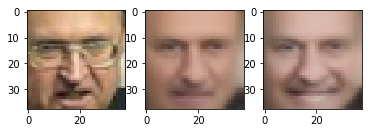

In [180]:
 # выберем фото из датасета

def plot_morphing(factor, index):
    #factor = 2 # насколько сильно мы меняем картинку

    img = X[index]
    code = encoded[index]
    plt.subplot(1,3,1)
    plt.imshow(img) # выводим оригинальное изображение
    code_open = code + male_direction*factor
    plt.subplot(1,3,2)
    plt.imshow(autoencoder.decode([code])[0])
    plt.subplot(1,3,3)
    plt.imshow(autoencoder.decode([code_open])[0]);
layout = widgets.Layout(width='100%', height='80px')
widgets.interact(plot_morphing, factor = widgets.FloatSlider(min=-10.0,max=10.,step= 0.1,layout=layout),
                 index = widgets.IntSlider(min=0,max=X.shape[0], step=1, layout=layout))